#  <span style="color:#3366ff"> <strong> Automatic image annotation / Dog Breed Recognition

#  <span style="color:#3366ff"> <strong> 20180913 (Part 1 CLASSIC)

<span style="color:#3366ff"> This notebook is dedicated to the pictures pre processing and treatment with a 'classic' method.

<span style="color:#ff0000"> Note 1: I had to create a specific environment "opencv2" & install this pack :
https://anaconda.org/menpo/opencv because SIFT is not available elsewhere.

<span style="color:#ff0000"> Note 2: The Clustering part has been done on an other environment (compatibility & memory issue), see Notebook <strong> 20181018_Automatic_pic_annotation_Dog_Breed_Recognition_CLASSIC_Part2_PCA_Clustering.ipynb

### Librairies Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image, ImageFilter, ImageOps

from sklearn import preprocessing, decomposition, cluster, metrics
from sklearn.feature_extraction import image
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from skimage.feature import match_template

import xml.etree.ElementTree as ET
from xml.dom import minidom

C:\Users\Arnaud\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
cv2.__version__

'2.4.11'

# Pre Processing: few tests

<strong> Equalisation

(Text(0.5,1,'Equalised Chihuahua'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

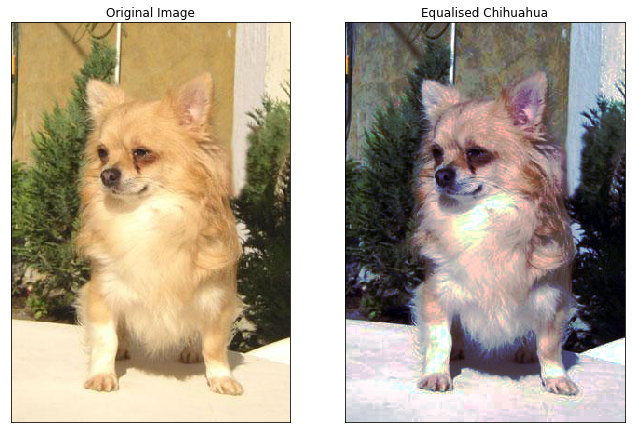

In [3]:
name_file = 'n02085620_199.jpg'    
img = Image.open(name_file)

img_eqa = ImageOps.equalize(img, mask=None)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_eqa,cmap = 'gray')
plt.title('Equalised Chihuahua'), plt.xticks([]), plt.yticks([])

In [4]:
def equa(img):
    img_eqa = ImageOps.equalize(img, mask=None)
    return img_eqa

<strong> Gaussian Filter

(Text(0.5,1,'Gaussian Filter'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

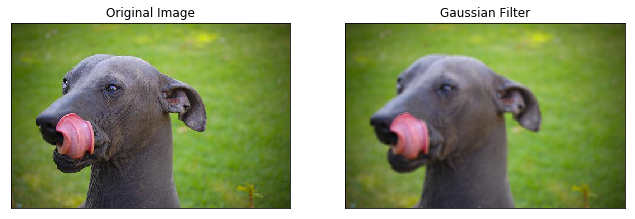

In [5]:
name_file = 'n02113978_310.jpg'  
img = Image.open(name_file)
img_gauss = img.filter(ImageFilter.BLUR)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_gauss,cmap = 'gray')
plt.title('Gaussian Filter'), plt.xticks([]), plt.yticks([])

In [6]:
def fil_gauss(name_file):
    #img = Image.open(name_file)
    img_gauss = name_file.filter(ImageFilter.BLUR)
    return img_gauss

<strong> Convolutional Filter

(Text(0.5,1,'Convolutional Filter'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

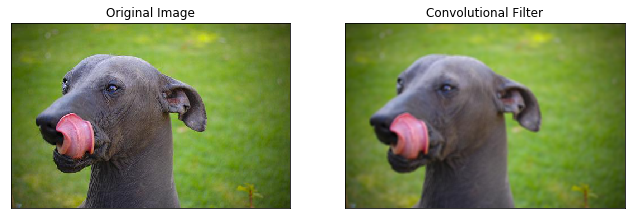

In [7]:
name_file = 'n02113978_310.jpg'  
img_raw = Image.open(name_file)
img = np.array(img_raw)

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(dst,cmap = 'gray')
plt.title('Convolutional Filter'), plt.xticks([]), plt.yticks([])

<strong> Bilateral Filter

(Text(0.5,1,'Bilateral Filter'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

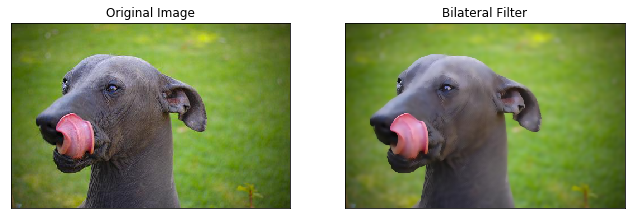

In [8]:
name_file = 'n02113978_310.jpg'  
img_raw = Image.open(name_file)
img = np.array(img_raw)

dst = cv2.bilateralFilter(img,9,75,75)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(dst,cmap = 'gray')
plt.title('Bilateral Filter'), plt.xticks([]), plt.yticks([])

In [9]:
def bila(namefile):
    dst = cv2.bilateralFilter(img,9,75,75)
    return dst

<strong> Image resizing --> not used

(Text(0.5,1,'Smaller Chihuahua'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

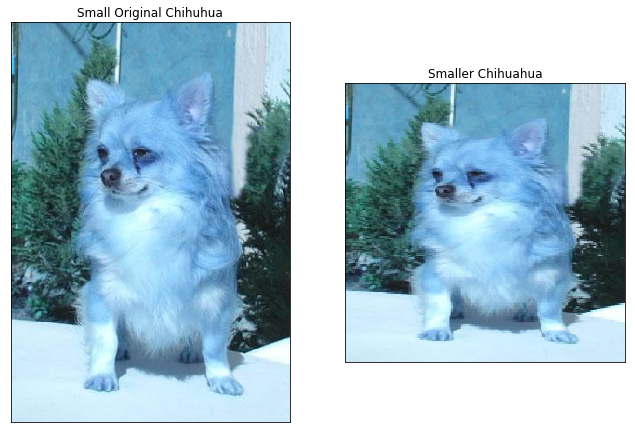

In [10]:
name_file = 'n02085620_199.jpg'    
#img = Image.open(name_file)
img = cv2.imread(name_file)
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

img_small = cv2.resize(img, dsize=(200, 200))

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Small Original Chihuhua'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_small,cmap = 'gray')
plt.title('Smaller Chihuahua'), plt.xticks([]), plt.yticks([])

<strong> Image background removal

In [11]:
# Rectange values: start x, start y, width, height
rectangle = (39, 52, 318, 279)

In [12]:
name_file = 'n02113978_310.jpg'  
img = cv2.imread(name_file)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create initial mask
mask = np.zeros(img.shape[:2], np.uint8)

# Create temporary arrays used by grabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Run grabCut
cv2.grabCut(image_rgb, # Our image
            mask, # The Mask
            rectangle, # Our rectangle
            bgdModel, # Temporary array for background
            fgdModel, # Temporary array for background
            5, # Number of iterations
            cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

# Create mask where sure and likely backgrounds set to 0, otherwise 1
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# Multiply image with new mask to subtract background
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

(Text(0.5,1,'Background removed'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

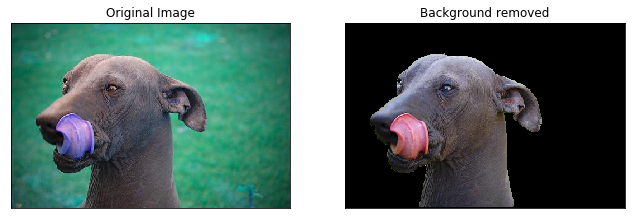

In [13]:
fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(image_rgb_nobg,cmap = 'gray')
plt.title('Background removed'), plt.xticks([]), plt.yticks([])

In [14]:
def backgr_rem(img, dirs, name_tmp):
    
    name_tronc = name_tmp[:-4]
    name_annot = "Annotation/" + dirs +"/" + name_tronc  
    
    annot = ET.parse(name_annot)
    root = annot.getroot()

    xmin = root[5][4][0].text
    xmin = int(xmin)
    ymin = root[5][4][1].text
    ymin = int(ymin)
    xmax = root[5][4][2].text
    xmax = int(xmax)
    ymax = root[5][4][3].text
    ymax = int(ymax)
    # Rectange values: start x, start y, width, height
    width_rect = xmax - xmin 
    height_rect = ymax - ymin
    rectangle = (xmin, ymin, width_rect, height_rect)
   
    #img = cv2.imread(name_file)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create initial mask
    mask = np.zeros(img.shape[:2], np.uint8)

    # Create temporary arrays used by grabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run grabCut
    cv2.grabCut(image_rgb, # Our image
                mask, # The Mask
                rectangle, # Our rectangle
                bgdModel, # Temporary array for background
                fgdModel, # Temporary array for background
                5, # Number of iterations
                cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

    # Create mask where sure and likely backgrounds set to 0, otherwise 1
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

    # Multiply image with new mask to subtract background
    image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]
    
    return image_rgb_nobg

In [15]:
name_tmp = "n02085620_199.jpg"
name_ = name_tmp[:-4]
name_

'n02085620_199'

In [16]:
name_dir = 'n02085620-Chihuahua'

In [17]:
name_annot = "Annotation/" + name_dir + '/' + name_
name_annot

'Annotation/n02085620-Chihuahua/n02085620_199'

In [18]:
test = ET.parse(name_annot)
test

In [19]:
for node in test.getroot():
    name = node.get("object")
    #email = node.find('email')
    #phone = node.find('phone')
    #street = node.find('address/street')
    print(node)

<Element 'folder' at 0x101e97b8>
<Element 'filename' at 0x101e9828>
<Element 'source' at 0x101e9470>
<Element 'size' at 0x101e9240>
<Element 'segment' at 0x101e9ac8>
<Element 'object' at 0x101e9b38>


In [20]:
root = test.getroot()
for child in root:
    print child.tag, child.attrib

folder {}
filename {}
source {}
size {}
segment {}
object {}


In [21]:
xmin = root[5][4][0].text
xmin

'65'

In [22]:
ymin = root[5][4][1].text
ymin

'50'

In [23]:
xmax = root[5][4][2].text
xmax

'249'

In [24]:
ymax = root[5][4][3].text
ymax

'404'

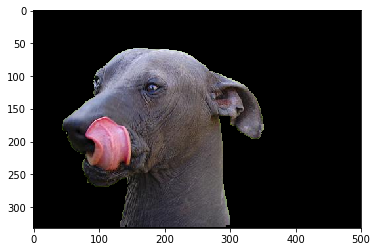

In [25]:
name_tmp = "n02113978_310.jpg"
dirs = "n02113978-Mexican_hairless"

name_file = "DATA/n02113978-Mexican_hairless/" + name_tmp        
img = cv2.imread(name_file)

uuu = backgr_rem(img, dirs, name_tmp)
plt.imshow(uuu)

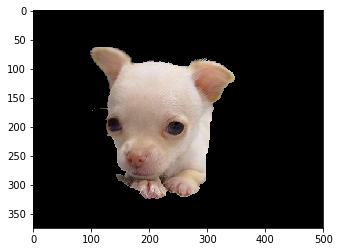

In [26]:
name_tmp = "n02085620_712.jpg"
dirs = "n02085620-Chihuahua"

name_file = "DATA/n02085620-Chihuahua/" + name_tmp        
img = cv2.imread(name_file)

uuu = backgr_rem(img, dirs, name_tmp)
plt.imshow(uuu)

<strong> Image reshaping 

(Text(0.5,1,'Reshaping: Focus on dog'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

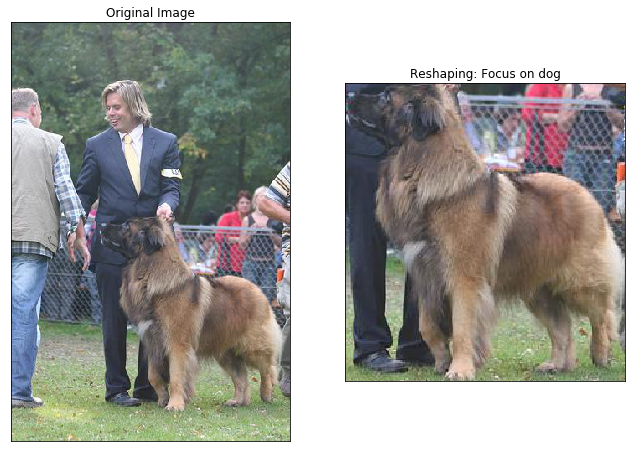

In [27]:
name_tmp = "n02111129_605.jpg"
dirs = "n02111129-Leonberg"

name_file = "DATA/n02111129-Leonberg/" + name_tmp 

img = Image.open(name_file)

name_tronc = name_tmp[:-4]
name_annot = "Annotation/" + dirs +"/" + name_tronc  
    
annot = ET.parse(name_annot)
root = annot.getroot()

xmin = root[5][4][0].text
xmin = int(xmin)
ymin = root[5][4][1].text
ymin = int(ymin)
xmax = root[5][4][2].text
xmax = int(xmax)
ymax = root[5][4][3].text
ymax = int(ymax)

# he crop rectangle, as a (left, upper, right, lower)-tuple.
crop_rectangle = (xmin, ymin, xmax, ymax)

cropped_im = img.crop(crop_rectangle)


fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cropped_im,cmap = 'gray')
plt.title('Reshaping: Focus on dog'), plt.xticks([]), plt.yticks([])

In [28]:
def reshape(img, dirs, name_tmp):
    name_tronc = name_tmp[:-4]
    name_annot = "Annotation/" + dirs +"/" + name_tronc  
    
    annot = ET.parse(name_annot)
    root = annot.getroot()

    xmin = root[5][4][0].text
    xmin = int(xmin)
    ymin = root[5][4][1].text
    ymin = int(ymin)
    xmax = root[5][4][2].text
    xmax = int(xmax)
    ymax = root[5][4][3].text
    ymax = int(ymax)

    # he crop rectangle, as a (left, upper, right, lower)-tuple.
    crop_rectangle = (xmin, ymin, xmax, ymax)

    cropped_im = img.crop(crop_rectangle)
    return cropped_im

(Text(0.5,1,'Pic reshaped'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

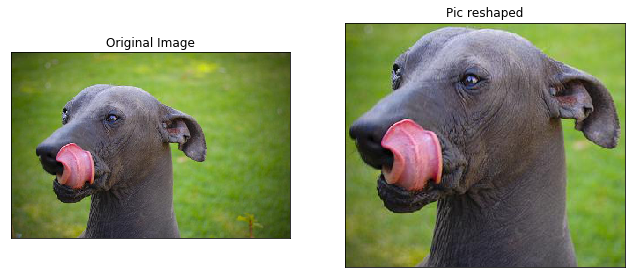

In [29]:
name_tmp = "n02113978_310.jpg"
dirs = "n02113978-Mexican_hairless"

name_file = "DATA/n02113978-Mexican_hairless/" + name_tmp        
img = Image.open(name_file)

uuu = reshape(img, dirs, name_tmp)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(uuu,cmap = 'gray')
plt.title('Pic reshaped'), plt.xticks([]), plt.yticks([])

### Canny Filter

https://docs.opencv.org/3.3.0/da/d22/tutorial_py_canny.html

(Text(0.5,1,'Canny Canin'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

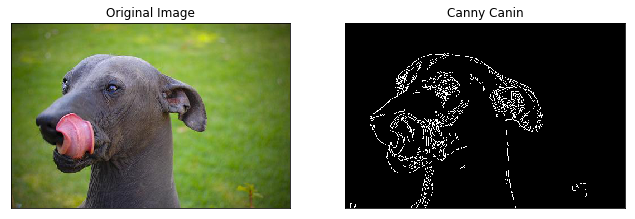

In [30]:
name_file = "n02113978_310.jpg"  
img = Image.open(name_file)
img_arr = np.array(img)
im_cann = cv2.Canny(img_arr,100, 200)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(im_cann,cmap = 'gray')
plt.title('Canny Canin'), plt.xticks([]), plt.yticks([])

In [31]:
def cann(image):
    #img = cv2.imread(image,0)
    edges = cv2.Canny(image,100, 200)
    return edges

In [32]:
def auto_canny(image):
    sigma=0.33
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    return edged

(Text(0.5,1,'Auto Canny'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

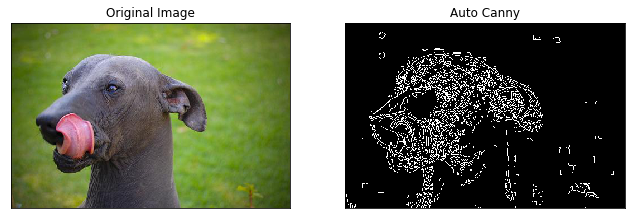

In [33]:
name_file = "n02113978_310.jpg"  
img = Image.open(name_file)

img_arr = np.array(img) 
img_auto_cann = auto_canny(img_arr)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_auto_cann,cmap = 'gray')
plt.title('Auto Canny'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Auto Canny + 2 X Gauss'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

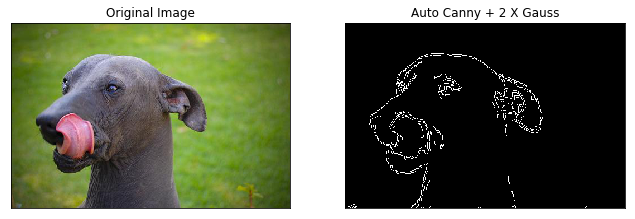

In [34]:
name_file = "n02113978_310.jpg"  
img = Image.open(name_file)
 
img_gauss = img.filter(ImageFilter.BLUR)
img_gauss_mat = np.array(img_gauss)  
img_auto_cann = auto_canny(img_gauss_mat)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_auto_cann,cmap = 'gray')
plt.title('Auto Canny + 2 X Gauss'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Auto Canny + Bilateral Filter'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

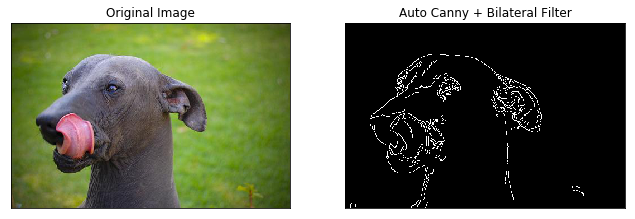

In [35]:
name_file = "n02113978_310.jpg"  
img_raw = Image.open(name_file)

img = np.array(img_raw)  
img_lin = bila(img)
img_lin_mat = np.array(img_lin)  
img_auto_cann = auto_canny(img_lin_mat)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_auto_cann,cmap = 'gray')
plt.title('Auto Canny + Bilateral Filter'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Auto Canny + Gauss + Bila'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

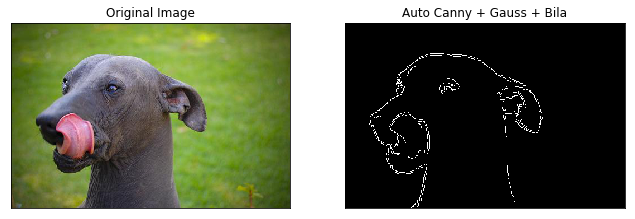

In [36]:
name_file = "n02113978_310.jpg"  
img_raw = Image.open(name_file)
 
img = np.array(img_raw)  
img_lin = bila(img)
cv2.imwrite("image_tmp1.jpg", img_lin)
image_tmp = Image.open("image_tmp1.jpg")
    
img_gauss = image_tmp.filter(ImageFilter.BLUR)
img_gauss_mat = np.array(img_gauss)  
img_auto_cann = auto_canny(img_gauss_mat)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_auto_cann,cmap = 'gray')
plt.title('Auto Canny + Gauss + Bila'), plt.xticks([]), plt.yticks([])

<strong> Test on Black and White picture

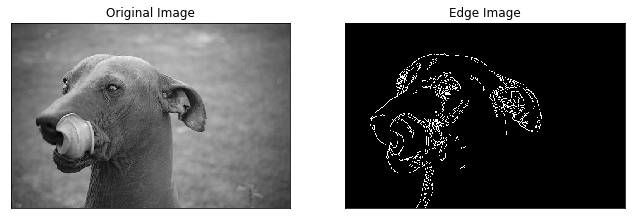

In [37]:
# n02085782_313.jpg
name_file = "n02113978_310.jpg"  
img = cv2.imread(name_file,0)
edges = cv2.Canny(img,100,200)


fig = plt.figure(figsize=(11,11))
plt.subplot(121),plt.imshow(img,
                            cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,
                            cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

# Features Extractions: tests

### SIFT Detector

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html?highlight=sift#

(Text(0.5,1,'Canin SIFTed'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

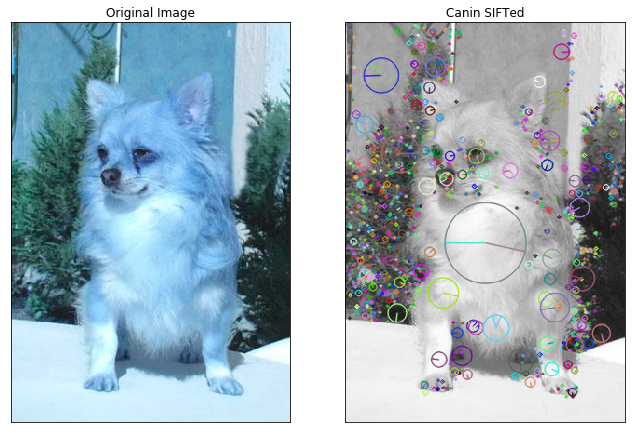

In [38]:
name_file = "n02085620_199.jpg"   
img = cv2.imread(name_file)
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT()
kp = sift.detect(gray,None)
img_sift=cv2.drawKeypoints(gray,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(11,11))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_sift,cmap = 'gray')
plt.title('Canin SIFTed'), plt.xticks([]), plt.yticks([])

In [39]:
(kp, descs) = sift.compute(img, kp)  
descs

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [37., 26.,  6., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 27.,  6., 18.],
       ...,
       [ 0.,  0., 11., ...,  9.,  4.,  1.],
       [ 0.,  4., 11., ...,  3., 15.,  2.],
       [ 4.,  5., 12., ...,  1., 11.,  3.]], dtype=float32)

In [40]:
descs.shape

(873L, 128L)

In [41]:
def siftatization(img):
    img_mat = np.array(img)
    gray= cv2.cvtColor(img_mat,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT()
    gray_mat = np.array(gray)
    kp = sift.detect(gray_mat,None)
    (kp, descs) = sift.compute(gray_mat, kp)  
    return descs

In [42]:
name_tmp = "n02085620_712.jpg"
    
img = cv2.imread(name_file)

ttt = siftatization(img)
ttt

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [37., 26.,  6., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 27.,  6., 18.],
       ...,
       [ 0.,  0., 11., ...,  9.,  4.,  1.],
       [ 0.,  4., 11., ...,  3., 15.,  2.],
       [ 4.,  5., 12., ...,  1., 11.,  3.]], dtype=float32)

In [43]:
ttt.shape

(873L, 128L)

<span style="color:#3366ff">  "128" is the size of each SIFT feature

# -----------------------------------------------------------------------------------------------------------

# Features Extration: on 5 dog's races

Images loading & processing:
- Equalization, 
- Bilateral Filter
- Gaussian Filter, 
- background removal, 
- Pic Resizing,
- Sift detector, 
- Feature DataFrame

In [44]:
category_feature_ = pd.DataFrame()
category_feature_full = pd.DataFrame()

for dirs in os.listdir("DATA_bis"):
    print("Folder =", dirs) 
    dir_tmp = "DATA_bis" + '/' + dirs
    for files in os.listdir(dir_tmp):
        #cat_feature = []
        
        print("_File =", files) 
        name_tmp = files.decode('UTF-8')
        name_file = dir_tmp + '/' + name_tmp
        
        img = Image.open(name_file)
        
        # EQUALIZATION
        img_equa = equa(img)
        print("__equa_OK")
           
        # BILATERAL FILTER
        img = np.array(img_equa)  
        img_lin = bila(img)
        cv2.imwrite("image_tmp1.jpg", img_lin)
        image_tmp = Image.open("image_tmp1.jpg")    
        print("__bila_OK")    
                       
        # GAUSSIAN FILTER
        img_gauss = image_tmp.filter(ImageFilter.BLUR)
        img_gauss_mat = np.array(img_gauss)     
        print("__Gauss_OK")
        
        # REMOVE BACKGROUND, with "annotation"
        img_focus = backgr_rem(img_gauss_mat, dirs, name_tmp)
        print("__background_OK") 
        
        # RESIZE  
        cv2.imwrite("image_tmp.jpg", img_focus)
        image_focus_tmp = Image.open("image_tmp.jpg")
        img_resh = reshape(image_focus_tmp, dirs, name_tmp)
        print("__Resize_OK")
        
        img_resh_name = "DATA_tmp_bis/" + name_tmp 
        img_resh_mat = np.array(img_resh)
        cv2.imwrite(img_resh_name, img_resh_mat)  
                    
        # SIFT
        feat_sift = siftatization(img_resh)
        print("__SIFT_OK")   
                        
        line_name = files[:-4]
        if not feat_sift is None:
            shape_sift = feat_sift.shape[0]
        
            indi = []
            for i in range(0,shape_sift):
                filename = line_name + "_" + str(i)
                indi.append(filename)
                
            category_feature = pd.DataFrame(feat_sift, index = [indi])#, columns = files)
            category_feature_ = pd.concat([category_feature_, category_feature], axis = 0)
    print("\n")    
print("FIN")

('Folder =', 'n02085936-Maltese_dog')
('_File =', 'n02085936_1155.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1244.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1247.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_126.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1288.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1325.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_137.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1390.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1424.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_1515.jpg')
__e

__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_4506.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_4569.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_4608.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_461.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_517.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_544.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_548.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_66.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02085936_719.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n0208593

__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3415.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3427.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3445.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3556.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_364.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3711.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3721.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3734.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3738.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02090379_3768.jpg')
__

__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2126.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2250.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2322.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2437.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2442.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2451.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_247.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2498.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02093991_2502.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_Fi

('_File =', 'n02105505_2083.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2101.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2134.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2155.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2156.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2178.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2270.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2281.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2316.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02105505_2322.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__backgr

('_File =', 'n02105505_955.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK


('Folder =', 'n02113978-Mexican_hairless')
('_File =', 'n02113978_1006.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_1034.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_1069.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_1088.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_118.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_1189.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_1238.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_124.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_131.jpg'

__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_573.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_605.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_697.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_700.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_737.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_759.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_773.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_838.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_839.jpg')
__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK
('_File =', 'n02113978_857.jpg')
__equa_OK
_

In [45]:
category_feature_.head(30)

0      1     2    3    4    5    6     7      8      9    \
n02085936_1155_0    22.0  120.0  54.0  0.0  0.0  0.0  0.0   0.0  120.0  154.0   
n02085936_1155_1     0.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0    0.0    0.0   
n02085936_1155_2     4.0    1.0   0.0  0.0  0.0  0.0  1.0   3.0  152.0   79.0   
n02085936_1155_3    24.0  165.0   4.0  0.0  0.0  0.0  0.0   0.0   14.0  165.0   
n02085936_1155_4     2.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0  144.0   12.0   
n02085936_1155_5     9.0    0.0   0.0  0.0  0.0  0.0  0.0   3.0  161.0    6.0   
n02085936_1155_6    45.0  161.0   4.0  0.0  0.0  0.0  0.0   0.0   21.0  161.0   
n02085936_1155_7     1.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0  155.0   23.0   
n02085936_1155_8    57.0   88.0   9.0  0.0  0.0  0.0  0.0   0.0  149.0  149.0   
n02085936_1155_9     1.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0   72.0    2.0   
n02085936_1155_10   27.0    6.0   1.0  0.0  0.0  0.0  0.0   1.0  165.0   45.0   
n02085936_1155_11    0.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0    0.0    0.0   
n02085936_1155_12  142.0    0.0   0.0  0.0  0.0  0.0  0.0  39.0  142.0    7.0   
n02085936_1155_13    4.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0  149.0    0.0   
n02085936_1155_14    0.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0    6.0    0.0   
n02085936_1155_15   12.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0  162.0    0.0   
n02085936_1155_16    0.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0  125.0    0.0   
n02085936_1155_17   51.0   27.0   0.0  0.0  0.0  0.0  0.0   0.0  171.0  153.0   
n02085936_1155_18   39.0   25.0   1.0  0.0  0.0  0.0  0.0   0.0  155.0  119.0   
n02085936_1155_19    0.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0    6.0    0.0   
n02085936_1155_20   30.0   17.0   0.0  0.0  0.0  0.0  0.0   0.0  156.0  156.0   
n02085936_1155_21   26.0   10.0   0.0  0.0  0.0  0.0  0.0   2.0  166.0   36.0   
n02085936_1155_22    1.0    0.0   0.0  0.0  0.0  0.0  0.0   1.0   74.0    1.0   
n02085936_1155_23    1.0    0.0   0.0  0.0  0.0  0.0  0.0   0.0  122.0    0.0   
n02085936_1155_24   26.0   71.0   0.0  0.0  0.0  0.0  0.0   0.0  154.0  169.0   
n02085936_1155_25    1.0    1.0   0.0  0.0  0.0  0.0  0.0   0.0  158.0   19.0   
n02085936_1155_26    2.0    1.0   0.0  0.0  0.0  0.0  0.0   0.0  161.0   61.0   
n02085936_1155_27   17.0    0.0   0.0  0.0  0.0  0.0  0.0   3.0  172.0    0.0   
n02085936_1155_28    0.0    0.0   1.0  1.0  0.0  0.0  0.0   0.0  123.0    0.0   
n02085936_1155_29    4.0    0.0   0.0  0.0  0.0  0.0  0.0   3.0  159.0    8.0   

                   ...   118    119    120    121    122   123  124  125  126  \
n02085936_1155_0   ...   0.0    0.0    0.0   18.0  100.0   4.0  0.0  0.0  0.0   
n02085936_1155_1   ...   0.0    1.0   15.0    2.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_2   ...   0.0    9.0   40.0   15.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_3   ...   0.0    2.0   52.0   19.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_4   ...   6.0   81.0    2.0    0.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_5   ...   0.0   35.0   12.0    1.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_6   ...   0.0  111.0   37.0    4.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_7   ...   2.0   85.0   13.0    3.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_8   ...   0.0    4.0    2.0  110.0  149.0   0.0  0.0  0.0  0.0   
n02085936_1155_9   ...   2.0   45.0   13.0    5.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_10  ...   0.0   16.0  123.0   22.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_11  ...   0.0   53.0    2.0    1.0    0.0   0.0  0.0  0.0  1.0   
n02085936_1155_12  ...   0.0    5.0   61.0   32.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_13  ...   0.0    0.0   28.0   14.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_14  ...   0.0    0.0   14.0    4.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_15  ...   0.0    2.0   27.0  100.0    2.0   0.0  0.0  0.0  0.0   
n02085936_1155_16  ...   0.0    0.0   18.0    3.0    0.0   0.0  0.0  0.0  0.0   
n02085936_1155_17  ...   0.0    0.0    8.0   16.0  

In [46]:
category_feature_.tail()

0     1     2    3    4     5     6     7      8     9    \
n02113978_996_309   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   16.0   0.0   
n02113978_996_310   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   92.0  25.0   
n02113978_996_311  43.0  23.0   0.0  0.0  0.0   0.0   0.0   0.0  116.0  45.0   
n02113978_996_312  83.0   1.0   0.0  0.0  0.0   0.0   0.0  34.0  133.0   1.0   
n02113978_996_313  13.0  50.0  22.0  1.0  3.0  14.0  19.0   9.0    8.0  21.0   

                  ...    118  119  120   121   122   123   124   125  126  127  
n02113978_996_309 ...    1.0  0.0  0.0  17.0  92.0  15.0   1.0   0.0  0.0  0.0  
n02113978_996_310 ...   10.0  4.0  0.0   0.0   1.0  16.0  73.0  15.0  0.0  0.0  
n02113978_996_311 ...    0.0  0.0  0.0   0.0   0.0   8.0   4.0   0.0  0.0  0.0  
n02113978_996_312 ...    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  
n02113978_996_313 ...    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  

[5 rows x 128 columns]

In [47]:
# Cette base num mesure
shape = category_feature_.shape

print("Cette base de features contient",shape[0], 
      "features de ", shape[1], "parametres.")

('Cette base de features contient', 88456, 'features de ', 128, 'parametres.')


In [48]:
category_feature_.to_csv(path_or_buf='DATA_tmp_bis/20181007_sift_feature.csv')

<strong> Test de recup pour clustering sur AWS

In [49]:
test= pd.read_csv(
    'DATA_tmp_bis/20181007_sift_feature.csv', 
    #sep='\t', 
    index_col=0,
    encoding='utf-8', 
    low_memory = False)

In [50]:
test.head(10)

0      1     2    3    4    5    6    7      8  \
('n02085936_1155_0',)  22.0  120.0  54.0  0.0  0.0  0.0  0.0  0.0  120.0   
('n02085936_1155_1',)   0.0    0.0   0.0  0.0  0.0  0.0  0.0  1.0    0.0   
('n02085936_1155_2',)   4.0    1.0   0.0  0.0  0.0  0.0  1.0  3.0  152.0   
('n02085936_1155_3',)  24.0  165.0   4.0  0.0  0.0  0.0  0.0  0.0   14.0   
('n02085936_1155_4',)   2.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  144.0   
('n02085936_1155_5',)   9.0    0.0   0.0  0.0  0.0  0.0  0.0  3.0  161.0   
('n02085936_1155_6',)  45.0  161.0   4.0  0.0  0.0  0.0  0.0  0.0   21.0   
('n02085936_1155_7',)   1.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  155.0   
('n02085936_1155_8',)  57.0   88.0   9.0  0.0  0.0  0.0  0.0  0.0  149.0   
('n02085936_1155_9',)   1.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0   72.0   

                           9  ...   118    119   120    121    122  123  124  \
('n02085936_1155_0',)  154.0  ...   0.0    0.0   0.0   18.0  100.0  4.0  0.0   
('n02085936_1155_1',)    0.0  ...   0.0    1.0  15.0    2.0    0.0  0.0  0.0   
('n02085936_1155_2',)   79.0  ...   0.0    9.0  40.0   15.0    0.0  0.0  0.0   
('n02085936_1155_3',)  165.0  ...   0.0    2.0  52.0   19.0    0.0  0.0  0.0   
('n02085936_1155_4',)   12.0  ...   6.0   81.0   2.0    0.0    0.0  0.0  0.0   
('n02085936_1155_5',)    6.0  ...   0.0   35.0  12.0    1.0    0.0  0.0  0.0   
('n02085936_1155_6',)  161.0  ...   0.0  111.0  37.0    4.0    0.0  0.0  0.0   
('n02085936_1155_7',)   23.0  ...   2.0   85.0  13.0    3.0    0.0  0.0  0.0   
('n02085936_1155_8',)  149.0  ...   0.0    4.0   2.0  110.0  149.0  0.0  0.0   
('n02085936_1155_9',)    2.0  ...   2.0   45.0  13.0    5.0    0.0  0.0  0.0   

                       125  126   127  
('n02085936_1155_0',)  0.0  0.0   0.0  
('n02085936_1155_1',)  0.0  0.0   2.0  
('n02085936_1155_2',)  0.0  0.0   0.0  
('n02085936_1155_3',)  0.0  0.0   0.0  
('n02085936_1155_4',)  0.0  0.0  17.0  
('n02085936_1155_5',)  0.0  0.0   1.0  
('n02085936_1155_6',)  0.0  0.0   5.0  
('n02085936_1155_7',)  0.0  0.0   6.0  
('n02085936_1155_8',)  0.0  0.0   0.0  
('n02085936_1155_9',)  0.0  0.0   1.0  

[10 rows x 128 columns]

In [51]:
test.tail()

0     1     2    3    4     5     6     7      8  \
('n02113978_996_309',)   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   16.0   
('n02113978_996_310',)   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   92.0   
('n02113978_996_311',)  43.0  23.0   0.0  0.0  0.0   0.0   0.0   0.0  116.0   
('n02113978_996_312',)  83.0   1.0   0.0  0.0  0.0   0.0   0.0  34.0  133.0   
('n02113978_996_313',)  13.0  50.0  22.0  1.0  3.0  14.0  19.0   9.0    8.0   

                           9 ...    118  119  120   121   122   123   124  \
('n02113978_996_309',)   0.0 ...    1.0  0.0  0.0  17.0  92.0  15.0   1.0   
('n02113978_996_310',)  25.0 ...   10.0  4.0  0.0   0.0   1.0  16.0  73.0   
('n02113978_996_311',)  45.0 ...    0.0  0.0  0.0   0.0   0.0   8.0   4.0   
('n02113978_996_312',)   1.0 ...    0.0  0.0  0.0   0.0   0.0   0.0   0.0   
('n02113978_996_313',)  21.0 ...    0.0  0.0  0.0   0.0   0.0   0.0   0.0   

                         125  126  127  
('n02113978_996_309',)   0.0  0.0  0.0  
('n02113978_996_310',)  15.0  0.0  0.0  
('n02113978_996_311',)   0.0  0.0  0.0  
('n02113978_996_312',)   0.0  0.0  0.0  
('n02113978_996_313',)   0.0  0.0  0.0  

[5 rows x 128 columns]

# Dimensions Réduction

### 2 first PCA

In [52]:
# preprocessing
category_feature_prepro = preprocessing.scale(category_feature_)

pca = decomposition.PCA(n_components=2)
pca.fit(category_feature_prepro)
print("Variance des 2 premieres composantes principales", 
      pca.explained_variance_ratio_.cumsum())

('Variance des 2 premieres composantes principales', array([0.08706146, 0.15517252]))


In [53]:
category_feature_prepro

array([[-0.1620541 ,  2.67594487,  1.27111743, ..., -0.51072066,
        -0.45673341, -0.5530238 ],
       [-0.75412174, -0.64646973, -0.51915874, ..., -0.51072066,
        -0.45673341, -0.47274483],
       [-0.64647308, -0.61878294, -0.51915874, ..., -0.51072066,
        -0.45673341, -0.5530238 ],
       ...,
       [ 0.40310138, -0.0096736 , -0.51915874, ..., -0.51072066,
        -0.45673341, -0.5530238 ],
       [ 1.479588  , -0.61878294, -0.51915874, ..., -0.51072066,
        -0.45673341, -0.5530238 ],
       [-0.40426359,  0.73786969,  0.21021303, ..., -0.51072066,
        -0.45673341, -0.5530238 ]])

In [54]:
category_feature_prepro_trans= pca.transform(category_feature_prepro)

# Cette base mesure
shape = category_feature_prepro_trans.shape

print("Le tableau des Composantes Principales contient",shape[0], 
      "features decrits avec", shape[1], "CP.")

('Le tableau des Composantes Principales contient', 88456L, 'features decrits avec', 2L, 'CP.')


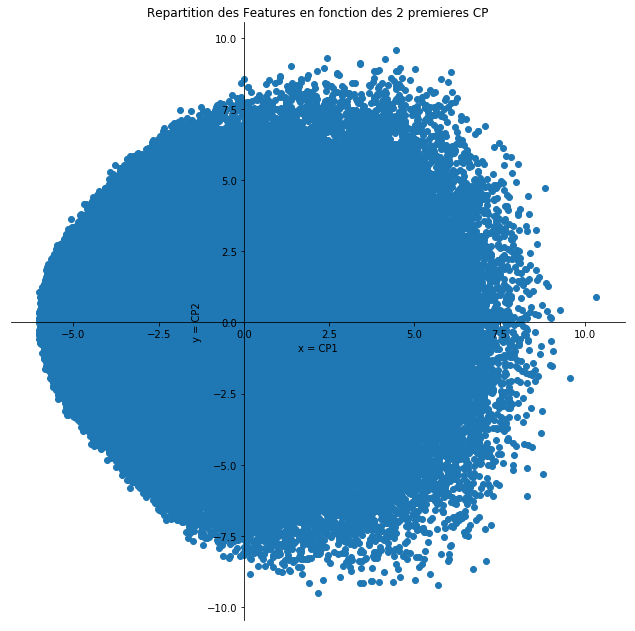

In [55]:
fig = plt.figure(figsize=(11,11))

ax = plt.subplot()
ax.set_title('Repartition des Features en fonction des 2 premieres CP')
plt.ylabel("y = CP2")
plt.xlabel("x = CP1")

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.scatter(category_feature_prepro_trans[:,0], category_feature_prepro_trans[:,1])

(-0.3, 0.3)

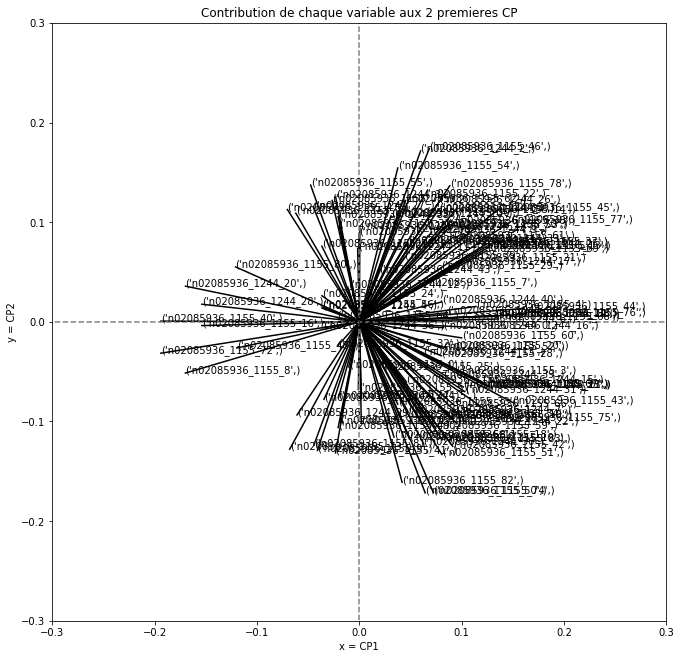

In [56]:
pcs = pca.components_

fig = plt.figure(figsize=(11,11))
ax = plt.subplot()
ax.set_title('Contribution de chaque variable aux 2 premieres CP')
plt.ylabel("y = CP2")
plt.xlabel("x = CP1")

for i , (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, category_feature_.index[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

In [57]:
pcs.shape

(2L, 128L)

PCA 3 

In [58]:
pca3 = decomposition.PCA(n_components=3)
pca3.fit(category_feature_prepro)
print("Variance des 3 premieres composantes principales", 
      pca3.explained_variance_ratio_.cumsum())

('Variance des 3 premieres composantes principales', array([0.08706146, 0.15517252, 0.21993429]))


In [59]:
category_feature_prepro_trans3= pca3.transform(category_feature_prepro)

# Cette base mesure
shape3 = category_feature_prepro_trans3.shape

print("Le tableau des Composantes Principales contient",shape3[0], 
      "features decrits avec", shape3[1], "CP.")

('Le tableau des Composantes Principales contient', 88456L, 'features decrits avec', 3L, 'CP.')


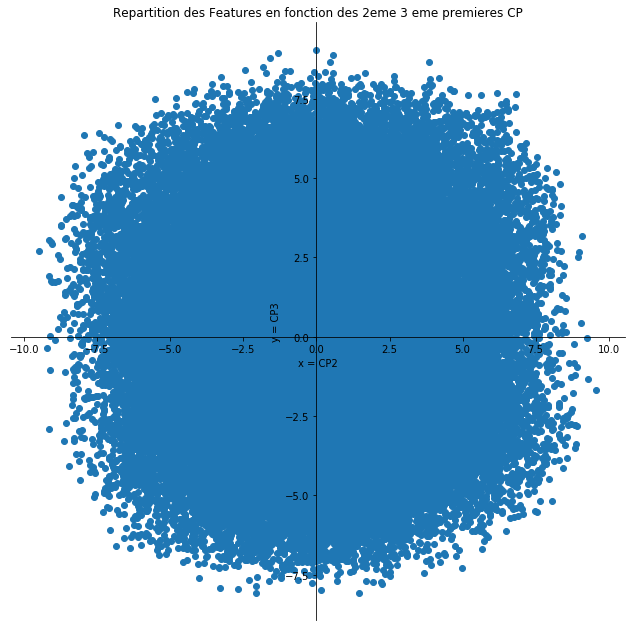

In [60]:
fig = plt.figure(figsize=(11,11))

ax = plt.subplot()
ax.set_title('Repartition des Features en fonction des 2eme 3 eme premieres CP')
plt.ylabel("y = CP3")
plt.xlabel("x = CP2")

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.scatter(category_feature_prepro_trans3[:,1], category_feature_prepro_trans3[:,2])

(-0.3, 0.3)

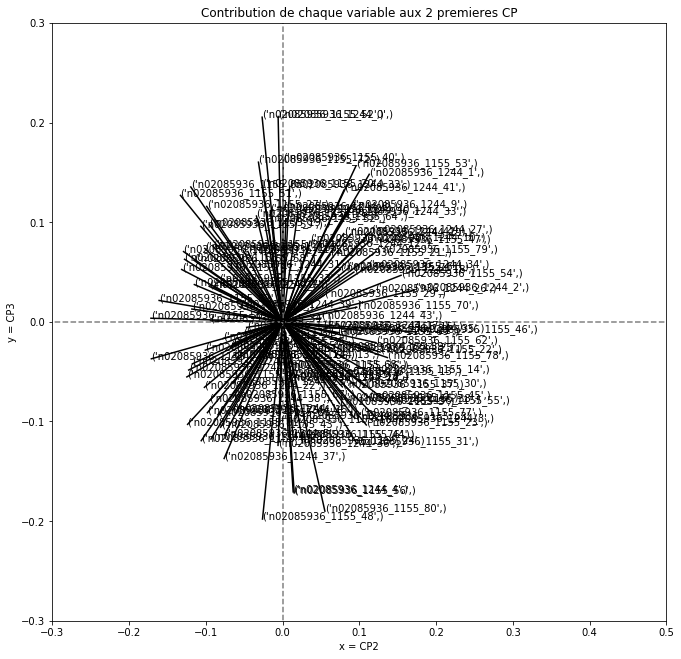

In [61]:
pcs3 = pca3.components_

fig = plt.figure(figsize=(11,11))
ax = plt.subplot()
ax.set_title('Contribution de chaque variable aux 2 premieres CP')
plt.ylabel("y = CP3")
plt.xlabel("x = CP2")

for i , (x, y) in enumerate(zip(pcs3[1, :], pcs3[2, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, category_feature_.index[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.3, 0.5])
plt.ylim([-0.3, 0.3])

# Visual words dictionnary

### Best Clustering: See Notebook

# Feature extraction :Visual words dictionnary : clustering

In [62]:
cls= cluster.KMeans(40, 
                    n_init=1, 
                    init='random')
cls.fit(category_feature_prepro_trans)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=40, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [63]:
cls.cluster_centers_.shape

(40L, 2L)

In [64]:
visual_words = cls.cluster_centers_
visual_words

array([[-1.26501701e+00,  2.54182218e+00],
       [-2.52825169e-01, -4.15815791e+00],
       [ 4.22742507e+00,  6.20631440e+00],
       [-4.33009206e+00,  2.81195273e+00],
       [ 6.10000406e+00, -3.05214684e+00],
       [ 4.47645966e+00, -1.64289604e+00],
       [-3.77186440e+00,  9.29101379e-02],
       [-4.74390620e+00, -1.54415405e+00],
       [-5.13756459e+00,  1.15396033e+00],
       [ 4.97127278e+00,  1.67570045e+00],
       [ 2.46514758e+00, -6.47825319e+00],
       [-1.48689976e+00, -2.66012294e+00],
       [-2.32131346e+00, -4.84792651e+00],
       [-2.27315775e-01, -6.37528631e+00],
       [-2.72660532e+00,  4.26527964e+00],
       [-5.42181051e+00, -1.59948552e-01],
       [ 6.28394357e+00, -9.45277731e-02],
       [-8.91685075e-01, -8.42211304e-01],
       [-1.91062178e+00,  5.77777124e-01],
       [ 1.84584212e+00,  7.46316601e-01],
       [ 4.11813344e+00,  3.73394281e+00],
       [ 4.93179198e+00, -5.78352869e+00],
       [ 1.42073996e+00,  6.43879898e+00],
       [ 2.

In [65]:
visual_words.shape

(40L, 2L)

In [66]:
visual_words[0]

array([-1.26501701,  2.54182218])

In [67]:
cls.labels_

array([12,  3,  6, ...,  1,  1, 38])

In [68]:
clusters= pd.DataFrame(data = cls.labels_, 
                      index = category_feature_.index, 
                      columns=['Clusters'])
clusters.head()

Clusters
n02085936_1155_0        12
n02085936_1155_1         3
n02085936_1155_2         6
n02085936_1155_3        25
n02085936_1155_4         3

<strong> test extract dog race from name

In [69]:
tab = [str(x)[2:11] for x in clusters.index]
tab = pd.DataFrame(tab, index = category_feature_.index, columns=['Race Code'])
tab.head()

Race Code
n02085936_1155_0  n02085936
n02085936_1155_1  n02085936
n02085936_1155_2  n02085936
n02085936_1155_3  n02085936
n02085936_1155_4  n02085936

In [70]:
# Score RFM / Value association
def Conv(x):
    if x == 'n02085936':   # Maltese_dog
        return int(1)
    elif x == 'n02090379': # redbone
        return int(2)
    elif x == 'n02093991': # Irish_terrier
        return int(3)
    elif x == 'n02105505': #  komondor
        return int(4)
    elif x == 'n02113978': # Mexican_hairless
        return int(5)

In [71]:
tab['Dog Race'] = tab['Race Code'].apply(lambda x: Conv(x))
tab['Dog Race'] = tab['Dog Race'].astype(int)

In [72]:
tab.head()

Race Code  Dog Race
n02085936_1155_0  n02085936         1
n02085936_1155_1  n02085936         1
n02085936_1155_2  n02085936         1
n02085936_1155_3  n02085936         1
n02085936_1155_4  n02085936         1

In [73]:
dog_race = pd.concat([tab, clusters], axis = 1)
dog_race.head()    

Race Code  Dog Race  Clusters
n02085936_1155_0  n02085936         1        12
n02085936_1155_1  n02085936         1         3
n02085936_1155_2  n02085936         1         6
n02085936_1155_3  n02085936         1        25
n02085936_1155_4  n02085936         1         3

In [74]:
dog_race.tail() 

Race Code  Dog Race  Clusters
n02113978_996_309  n02113978         5        37
n02113978_996_310  n02113978         5        24
n02113978_996_311  n02113978         5         1
n02113978_996_312  n02113978         5         1
n02113978_996_313  n02113978         5        38

<strong> test extract num image from index

In [75]:
def num_split(x):
    y = x.split('_')[1]
    z = x.split('_')[0]
    u = z + "_" + y
    return u

In [76]:
tab2 = [num_split(str(x)) for x in dog_race.index]
tab2 = pd.DataFrame(tab2, index = dog_race.index, columns=['Picture'])
tab2.head()

Picture
n02085936_1155_0  ('n02085936_1155
n02085936_1155_1  ('n02085936_1155
n02085936_1155_2  ('n02085936_1155
n02085936_1155_3  ('n02085936_1155
n02085936_1155_4  ('n02085936_1155

In [77]:
dog_race = pd.concat([tab2, dog_race], axis = 1)
dog_race.head()    

Picture  Race Code  Dog Race  Clusters
n02085936_1155_0  ('n02085936_1155  n02085936         1        12
n02085936_1155_1  ('n02085936_1155  n02085936         1         3
n02085936_1155_2  ('n02085936_1155  n02085936         1         6
n02085936_1155_3  ('n02085936_1155  n02085936         1        25
n02085936_1155_4  ('n02085936_1155  n02085936         1         3

<strong> Final Table Creation

In [78]:
t1 = pd.concat([tab2, clusters], axis = 1)
t1.head(10)    

Picture  Clusters
n02085936_1155_0  ('n02085936_1155        12
n02085936_1155_1  ('n02085936_1155         3
n02085936_1155_2  ('n02085936_1155         6
n02085936_1155_3  ('n02085936_1155        25
n02085936_1155_4  ('n02085936_1155         3
n02085936_1155_5  ('n02085936_1155        15
n02085936_1155_6  ('n02085936_1155         7
n02085936_1155_7  ('n02085936_1155         3
n02085936_1155_8  ('n02085936_1155        25
n02085936_1155_9  ('n02085936_1155         8

In [79]:
t1['Nb Cluster per image'] = t1['Clusters']
t1.head()  

Picture  Clusters  Nb Cluster per image
n02085936_1155_0  ('n02085936_1155        12                    12
n02085936_1155_1  ('n02085936_1155         3                     3
n02085936_1155_2  ('n02085936_1155         6                     6
n02085936_1155_3  ('n02085936_1155        25                    25
n02085936_1155_4  ('n02085936_1155         3                     3

In [80]:
t1_sum = t1.groupby(['Picture', 'Clusters']).count()
t1_sum.head(20)

Nb Cluster per image
Picture          Clusters                      
('n02085936_1155 0                            1
                 3                            7
                 5                            1
                 6                            4
                 7                            7
                 8                            8
                 10                           1
                 11                           1
                 12                           4
                 14                           6
                 15                          22
                 17                           2
                 18                           5
                 19                           2
                 24                           1
                 25                           3
                 26                           1
                 30                           2
                 31                           3
                 32                           1

In [81]:
t1_sum.tail(40)

Nb Cluster per image
Picture         Clusters                      
('n02113978_996 0                            7
                1                           12
                2                            4
                3                            3
                4                            2
                5                            7
                6                           16
                7                            8
                8                            3
                9                           11
                10                           7
                11                          10
                12                           4
                13                           7
                14                           3
                15                           5
                16                           4
                17                          15
                18                          18
                19                          10
                20                           8
                21                           2
                22                           7
                23                          14
                24                          11
                25                           6
                26                          11
                27                          13
                28                           6
                29                           5
                30                           4
                31                           9
                32                           2
                33                          10
                34                          11
                35                          10
                36                           8
                37                           6
                38                          13
                39                           2

In [82]:
t2_sum = t1_sum.reset_index()

In [83]:
t2_sum = t2_sum.set_index(['Picture'])

t2_sum = t2_sum.head(80)

In [84]:
t2_sum.head(10)

Clusters  Nb Cluster per image
Picture                                         
('n02085936_1155         0                     1
('n02085936_1155         3                     7
('n02085936_1155         5                     1
('n02085936_1155         6                     4
('n02085936_1155         7                     7
('n02085936_1155         8                     8
('n02085936_1155        10                     1
('n02085936_1155        11                     1
('n02085936_1155        12                     4
('n02085936_1155        14                     6

test_sum3 = test_sum2.reset_index()
final_tab = test_sum3.pivot(index='Picture', 
                columns='Clusters', 
                values='Nb Cluster per image')

final_tab.head()

In [85]:
t3_sum = t2_sum.reset_index()
final_tab = t3_sum.pivot(index='Picture', 
                columns='Clusters', 
                values='Nb Cluster per image')

final_tab.head()

Clusters           0    1    2    3    4    5    6     7     8     9  ...   \
Picture                                                               ...    
('n02085936_1155  1.0  NaN  NaN  7.0  NaN  1.0  4.0   7.0   8.0   NaN ...    
('n02085936_1244  3.0  2.0  3.0  3.0  NaN  2.0  2.0   2.0   5.0   4.0 ...    
('n02085936_1247  NaN  NaN  NaN  7.0  NaN  3.0  1.0   8.0  10.0   4.0 ...    
('n02085936_126   NaN  1.0  1.0  4.0  2.0  1.0  NaN  10.0  16.0   NaN ...    
('n02085936_1288  NaN  1.0  NaN  3.0  2.0  6.0  5.0   4.0  12.0  19.0 ...    

Clusters           30   31   32   33   34   35   36   37   38   39  
Picture                                                             
('n02085936_1155  2.0  3.0  1.0  NaN  1.0  1.0  NaN  NaN  NaN  NaN  
('n02085936_1244  2.0  3.0  1.0  1.0  2.0  NaN  3.0  3.0  2.0  1.0  
('n02085936_1247  NaN  NaN  NaN  NaN  1.0  1.0  NaN  NaN  1.0  NaN  
('n02085936_126   1.0  1.0  NaN  NaN  2.0  1.0  NaN  1.0  3.0  3.0  
('n02085936_1288  2.0  1.0  7.0  1.0  2.0  1.0  2.0  7.0  3.0  NaN  

[5 rows x 40 columns]

In [86]:
final_tab.shape

(486, 40)

In [87]:
final_tab = final_tab.fillna(0)

In [88]:
final_tab2=pd.DataFrame()
final_tab2['Race Code'] = [str(x)[2:11] for x in final_tab.index]
final_tab2.head()

Race Code
0  n02085936
1  n02085936
2  n02085936
3  n02085936
4  n02085936

In [89]:
final_tab2['Dog Race'] = final_tab2['Race Code'].apply(lambda x: Conv(x))
final_tab2['Dog Race'] = final_tab2['Dog Race'].astype(int)
final_tab2.head()

Race Code  Dog Race
0  n02085936         1
1  n02085936         1
2  n02085936         1
3  n02085936         1
4  n02085936         1

final_tab['Race Code'] = [str(x)[2:11] for x in final_tab.index]
final_tab.head()

final_tab['Dog Race'] = final_tab['Race Code'].apply(lambda x: Conv(x))
final_tab['Dog Race'] = final_tab['Dog Race'].astype(int)
final_tab.head()

In [90]:
final_tab.tail()

Clusters          0     1    2     3    4    5     6     7     8     9  ...   \
Picture                                                                 ...    
('n02113978_839  9.0   6.0  3.0   5.0  2.0  5.0  16.0  10.0  13.0  10.0 ...    
('n02113978_857  6.0   9.0  3.0  10.0  3.0  3.0  18.0   9.0  10.0   3.0 ...    
('n02113978_870  7.0   0.0  2.0   0.0  4.0  4.0   7.0   0.0   0.0   4.0 ...    
('n02113978_961  5.0   2.0  0.0   3.0  0.0  0.0   3.0   2.0   1.0   2.0 ...    
('n02113978_996  7.0  12.0  4.0   3.0  2.0  7.0  16.0   8.0   3.0  11.0 ...    

Clusters          30    31   32    33    34    35   36   37    38   39  
Picture                                                                 
('n02113978_839  6.0  10.0  5.0   8.0  11.0   6.0  6.0  7.0  13.0  1.0  
('n02113978_857  1.0   7.0  0.0   7.0   6.0   7.0  7.0  3.0   7.0  3.0  
('n02113978_870  4.0   5.0  2.0   3.0   6.0   4.0  3.0  8.0   7.0  1.0  
('n02113978_961  0.0   1.0  0.0   3.0   4.0   4.0  2.0  5.0   5.0  2.0  
('n02113978_996  4.0   9.0  2.0  10.0  11.0  10.0  8.0  6.0  13.0  2.0  

[5 rows x 40 columns]

In [91]:
Y = final_tab2.filter(items=(['Dog Race']))

In [92]:
Y.head()

Dog Race
0         1
1         1
2         1
3         1
4         1

In [93]:
Y.shape

(486, 1)

In [94]:
final_tab.head()

Clusters           0    1    2    3    4    5    6     7     8     9  ...   \
Picture                                                               ...    
('n02085936_1155  1.0  0.0  0.0  7.0  0.0  1.0  4.0   7.0   8.0   0.0 ...    
('n02085936_1244  3.0  2.0  3.0  3.0  0.0  2.0  2.0   2.0   5.0   4.0 ...    
('n02085936_1247  0.0  0.0  0.0  7.0  0.0  3.0  1.0   8.0  10.0   4.0 ...    
('n02085936_126   0.0  1.0  1.0  4.0  2.0  1.0  0.0  10.0  16.0   0.0 ...    
('n02085936_1288  0.0  1.0  0.0  3.0  2.0  6.0  5.0   4.0  12.0  19.0 ...    

Clusters           30   31   32   33   34   35   36   37   38   39  
Picture                                                             
('n02085936_1155  2.0  3.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  
('n02085936_1244  2.0  3.0  1.0  1.0  2.0  0.0  3.0  3.0  2.0  1.0  
('n02085936_1247  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  
('n02085936_126   1.0  1.0  0.0  0.0  2.0  1.0  0.0  1.0  3.0  3.0  
('n02085936_1288  2.0  1.0  7.0  1.0  2.0  1.0  2.0  7.0  3.0  0.0  

[5 rows x 40 columns]

L

# MACHINE LEARNING: Classification

In [95]:
scaler_X = preprocessing.StandardScaler().fit(final_tab)
X_scaled = scaler_X.transform(final_tab) 
X_scaled.shape

(486L, 40L)

In [96]:
rfcCV = RandomForestClassifier()

parameters = {
              'n_estimators': [3,4,5, 10, 50, 100, 150, 200, 250, 300],
              'max_depth':range(3,7)
             }

clf = GridSearchCV(rfcCV, 
                   parameters, 
                   n_jobs=4, 
                   cv=10)
clf.fit(X_scaled, Y)

print ("The RFC + CV Accuracy is:",
    (clf.best_score_*100), 
      "% with parameters:", 
    clf.best_params_) 

C:\Users\Arnaud\Anaconda3\envs\opencv\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


('The RFC + CV Accuracy is:', 50.0, '% with parameters:', {'n_estimators': 250, 'max_depth': 6})


In [97]:
gbCV4 = GradientBoostingClassifier()

parameters = {
              'n_estimators': [3,4,5, 10, 50,100,110,120,150,200,300,400,500],
              'max_depth':range(3,7)
             }

clfGB4 = GridSearchCV(gbCV4, parameters, n_jobs=4, cv=10)
clfGB4.fit(X_scaled, Y)

print ("The GB + CV Accuracy with Base 4 is: ",
    (clfGB4.best_score_*100), 
      "% with parameters:", 
    clfGB4.best_params_) 

C:\Users\Arnaud\Anaconda3\envs\opencv\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


('The GB + CV Accuracy with Base 4 is: ', 48.559670781893004, '% with parameters:', {'n_estimators': 50, 'max_depth': 3})


# Prediction

<strong> Image de test n02105505 "komondor" Classe 4

In [99]:
name_file = "DATA_raw/Images/n02105505-komondor/n02105505_4311.jpg"  
dirs = 'n02105505-komondor'
name_tmp = 'n02105505_4311.jpg'

img = Image.open(name_file)
# EQUALIZATION
img_equa = equa(img)
print("__equa_OK")

# BILATERAL FILTER 
img = np.array(img_equa)  
img_lin = bila(img)
cv2.imwrite("image_tmp1.jpg", img_lin)
image_tmp = Image.open("image_tmp1.jpg")    
print("__bila_OK")    
               
# GAUSSIAN FILTER
img_gauss = image_tmp.filter(ImageFilter.BLUR)
img_gauss_mat = np.array(img_gauss)     
print("__Gauss_OK")

# REMOVE BACKGROUND, with "annotation"
img_focus = backgr_rem(img_gauss_mat, dirs, name_tmp)
print("__background_OK") 

# RESIZE  
cv2.imwrite("image_tmp.jpg", img_focus)
image_focus_tmp = Image.open("image_tmp.jpg")
img_resh = reshape(image_focus_tmp, dirs, name_tmp)
print("__Resize_OK")

img_resh_name = "DATA_tmp_bis/" + name_tmp 
img_resh_mat = np.array(img_resh)
cv2.imwrite(img_resh_name, img_resh_mat)  

# SIFT
feat_sift = siftatization(img_resh)
print("__SIFT_OK")  

line_name = name_file[:-4]
if not feat_sift is None:
    shape_sift = feat_sift.shape[0]
    
    category_feature2 = pd.DataFrame(feat_sift)

__equa_OK
__bila_OK
__Gauss_OK
__background_OK
__Resize_OK
__SIFT_OK


In [100]:
category_feature2.head()

0     1     2      3      4     5    6     7      8      9    ...    118  \
0  23.0  13.0   0.0    0.0    0.0   0.0  0.0   0.0  168.0   65.0  ...    0.0   
1  43.0  11.0   0.0    0.0   19.0  29.0  3.0   5.0  101.0  124.0  ...   35.0   
2   3.0  16.0  12.0  144.0  113.0   0.0  0.0   0.0   22.0   61.0  ...    1.0   
3   0.0   0.0   0.0    9.0  144.0  57.0  1.0   0.0   73.0    1.0  ...   12.0   
4  33.0  58.0  16.0   13.0   10.0   4.0  6.0  17.0   45.0   16.0  ...    5.0   

    119   120    121   122   123  124  125   126   127  
0  21.0  42.0    2.0   1.0   3.0  0.0  0.0   0.0   3.0  
1  96.0  28.0    6.0   0.0   2.0  3.0  3.0  10.0  62.0  
2  16.0  18.0  118.0  18.0   9.0  0.0  0.0   0.0   0.0  
3  38.0  34.0   18.0   5.0   1.0  3.0  2.0   1.0   5.0  
4   0.0   3.0   80.0  47.0  43.0  5.0  2.0   2.0   1.0  

[5 rows x 128 columns]

In [101]:
category_feature2.shape

(138, 128)

<strong> PCA

In [102]:
category_feature_prepro2 = preprocessing.scale(category_feature2)

In [103]:
category_feature_prepro_trans2= pca.transform(category_feature_prepro2)

<strong> Clusters Prediction

In [104]:
clus_pred = cls.predict(category_feature_prepro_trans2)
clus_pred

array([15, 19, 26, 29, 31, 24, 36, 35,  8, 36, 20,  8, 19, 15,  7,  8, 25,
       17, 24, 36, 31,  7, 14, 12, 14,  3, 25,  3,  7, 26, 20, 30, 17, 23,
       24, 23, 37, 30, 13,  8, 36, 24, 35, 29, 36,  2, 10, 36, 30, 30, 20,
       35, 15, 11, 33, 25,  8,  7,  3, 15, 23, 14, 12, 33, 39,  0, 21, 19,
       29, 29, 33, 24, 10, 29, 24, 23, 23, 17, 28,  2, 37, 35, 29,  4, 29,
        0, 38, 36, 36,  8, 36, 18, 32, 10,  4, 31,  7, 35, 39, 24, 11, 31,
       18, 21, 27, 17, 23, 21, 38, 34, 11, 22, 24,  6,  6, 29,  6, 15,  3,
       30, 20, 36,  2, 22,  8,  8, 21, 20,  7, 35,  6, 25,  6, 34, 34, 24,
        9,  9])

In [105]:
clus_pred.shape

(138L,)

In [106]:
clusters2= pd.DataFrame(data = clus_pred,
                        columns=['Clusters'])
clusters2.head()

Clusters
0        15
1        19
2        26
3        29
4        31

In [107]:
clusters2['Nb Cluster per image'] = clusters2['Clusters']
clusters2.head() 

Clusters  Nb Cluster per image
0        15                    15
1        19                    19
2        26                    26
3        29                    29
4        31                    31

In [108]:
clusters2_sum = clusters2.groupby(['Clusters']).count()
clusters2_sum.head(20)

Nb Cluster per image
Clusters                      
0                            2
2                            3
3                            4
4                            2
6                            5
7                            6
8                            8
9                            2
10                           3
11                           3
12                           2
13                           1
14                           3
15                           5
17                           4
18                           2
19                           3
20                           5
21                           4
22                           2

In [109]:
clusters2_sum = clusters2_sum.reset_index()

In [110]:
clusters2_sum.head()

Clusters  Nb Cluster per image
0         0                     2
1         2                     3
2         3                     4
3         4                     2
4         6                     5

In [111]:
clusters2_sum.tail()

Clusters  Nb Cluster per image
32        35                     6
33        36                    10
34        37                     2
35        38                     2
36        39                     2

In [112]:
longueur = len(clusters2_sum)
longueur

37

In [113]:
d0 = pd.DataFrame(np.zeros((longueur, 1)), columns = ['Trame'])

In [114]:
clusters3_sum = pd.concat([d0, clusters2_sum], axis = 1)
clusters3_sum.head()

Trame  Clusters  Nb Cluster per image
0    0.0         0                     2
1    0.0         2                     3
2    0.0         3                     4
3    0.0         4                     2
4    0.0         6                     5

In [115]:
clusters3_sum = clusters3_sum.set_index(['Trame'])
clusters3_sum.head()

Clusters  Nb Cluster per image
Trame                                
0.0           0                     2
0.0           2                     3
0.0           3                     4
0.0           4                     2
0.0           6                     5

In [116]:
trame = pd.DataFrame(data = [0,0,0,0,0,0,0,0,0,0,
                             0,0,0,0,0,0,0,0,0,0,
                             0,0,0,0,0,0,0,0,0,0,
                             0,0,0,0,0,0,0,0,0,0], 
                     index = ['0','1','2','3','4','5','6','7','8','9',
                              '10','11','12','13','14','15','16','17','18','19',
                              '20','21','22','23','24','25','26','27','28','29',
                              '30','31','32','33','34','35','36','37','38','39'], 
                    columns = ['Nb Cluster per image'])

trame = trame.reset_index()

In [117]:
longueur2 = len(trame)
longueur2

40

In [118]:
d1 = pd.DataFrame(np.ones((longueur2, 1)), columns = ['Trame'])
d1.head()

Trame
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0

In [119]:
trame2 = pd.concat([d1, trame], axis = 1)
trame2.head()

Trame index  Nb Cluster per image
0    1.0     0                     0
1    1.0     1                     0
2    1.0     2                     0
3    1.0     3                     0
4    1.0     4                     0

In [120]:
trame3 = trame2.set_index(['Trame'])
trame3.head()

index  Nb Cluster per image
Trame                            
1.0       0                     0
1.0       1                     0
1.0       2                     0
1.0       3                     0
1.0       4                     0

In [121]:
trame3['Clusters'] = trame3['index']
trame3.head()

index  Nb Cluster per image Clusters
Trame                                     
1.0       0                     0        0
1.0       1                     0        1
1.0       2                     0        2
1.0       3                     0        3
1.0       4                     0        4

In [122]:
trame4 = trame3.filter(items=(['Clusters','Nb Cluster per image']))
trame4.head()

Clusters  Nb Cluster per image
Trame                               
1.0          0                     0
1.0          1                     0
1.0          2                     0
1.0          3                     0
1.0          4                     0

In [123]:
trame5 = pd.concat([clusters3_sum, trame4], axis = 0)
trame5.head(30)

Clusters  Nb Cluster per image
Trame                               
0.0          0                     2
0.0          2                     3
0.0          3                     4
0.0          4                     2
0.0          6                     5
0.0          7                     6
0.0          8                     8
0.0          9                     2
0.0         10                     3
0.0         11                     3
0.0         12                     2
0.0         13                     1
0.0         14                     3
0.0         15                     5
0.0         17                     4
0.0         18                     2
0.0         19                     3
0.0         20                     5
0.0         21                     4
0.0         22                     2
0.0         23                     6
0.0         24                     9
0.0         25                     4
0.0         26                     2
0.0         27                     1
0.0         28                     1
0.0         29                     8
0.0         30                     5
0.0         31                     4
0.0         32                     1

In [124]:
trame5['Clusters'] = trame5['Clusters'].astype('int')

In [125]:
trame6 = trame5.reset_index()
trame7 = trame6.pivot(index='Trame',
                      columns='Clusters',
                      values='Nb Cluster per image')

trame7.head()

Clusters   0    1    2    3    4    5    6    7    8    9  ...    30   31  \
Trame                                                      ...              
0.0       2.0  NaN  3.0  4.0  2.0  NaN  5.0  6.0  8.0  2.0 ...   5.0  4.0   
1.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   

Clusters   32   33   34   35    36   37   38   39  
Trame                                              
0.0       1.0  3.0  3.0  6.0  10.0  2.0  2.0  2.0  
1.0       0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  

[2 rows x 40 columns]

In [126]:
trame7 = trame7.fillna(0)

In [127]:
trame7

Clusters   0    1    2    3    4    5    6    7    8    9  ...    30   31  \
Trame                                                      ...              
0.0       2.0  0.0  3.0  4.0  2.0  0.0  5.0  6.0  8.0  2.0 ...   5.0  4.0   
1.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   

Clusters   32   33   34   35    36   37   38   39  
Trame                                              
0.0       1.0  3.0  3.0  6.0  10.0  2.0  2.0  2.0  
1.0       0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  

[2 rows x 40 columns]

In [128]:
trame7.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39],
           dtype='int64', name=u'Clusters')

In [129]:
trame8 = pd.DataFrame(trame7.iloc[0])
trame8 = trame8.T
trame8.head()

Clusters   0    1    2    3    4    5    6    7    8    9  ...    30   31  \
0.0       2.0  0.0  3.0  4.0  2.0  0.0  5.0  6.0  8.0  2.0 ...   5.0  4.0   

Clusters   32   33   34   35    36   37   38   39  
0.0       1.0  3.0  3.0  6.0  10.0  2.0  2.0  2.0  

[1 rows x 40 columns]

<strong> The RFC + CV Accuracy is:', 51.028806584362144, '% with parameters:', {'n_estimators': 100, 'max_depth': 6})

In [130]:
scaler_X2 = preprocessing.StandardScaler().fit(trame8)
X_scaled2 = scaler_X2.transform(trame8) 
X_scaled2.shape

(1L, 40L)

In [131]:
rfcBest4 = RandomForestClassifier(n_estimators=300, max_depth=6)

modelBest4 = rfcBest4.fit(X_scaled, Y)

predBest4 = rfcBest4.predict(X_scaled2)
predBest4

C:\Users\Arnaud\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([3])